In [1]:
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# <center>Karthick Venkatesan</center>
### <center>karvenka@umail.iu.edu</center>

## 1. Introduction

Airbnb is an online marketplace and hospitality service, enabling people to lease or rent short-term lodging including vacation rentals, apartment rentals, homestays, hostel beds, or hotel rooms. In order for Airbnb to provide a personalized experience for its customers, it
has explored the possibility of predicting the country destination in which a user will make a booking.
With this information, Airbnb can create more personalized content with its member community, decrease
the average time to first booking, and better forecast demand. These goals provide mutual benefit to
Airbnb and its customers: personal recommendations can improve customer engagement with the
platform, thus encouraging both repeat bookings and referrals to Airbnb for those in a customer’s network
of close friends and family.

This report details the analysis and results  for [Airbnb New User Bookings challenge][1] which was run in Kaggle. In the competition the participants were provided with data from Airbnb customers  and the task is to predict the first
booking destination for new Airbnb customers travelling from the United States. The response variable is
the destination where the booking is made. This can be one of 12 possible values: ' US', 'FR', 'CA', 'GB',
'ES', 'IT', 'PT', 'NL',' DE', 'AU', 'NDF', and 'other'. All of these correspond to two letter country
abbreviations with the exception of ‘NDF’, which corresponds to ‘No destination found’ and implies that
the user has not made a booking.

[1]: https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings

The evaluation metric for this competition is NDCG (Normalized discounted cumulative gain) @k where k=5. The details of the NDCG calculation are available [here][1].

[1]: https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings#evaluation

## 2. Dataset

### Description of the Dataset
The Airbnb challenege has the below datasets - a list of users along with their demographics, web session records, and some summary statistics. We need to predict which country a new user's first booking destination will be. All the users in the dataset are from the USA.

There are 12 possible outcomes of the destination country: 'US', 'FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL','DE', 'AU', 'NDF' (no destination found), and 'other'. 'other' means there was a booking, but is to a country not included in the list, while 'NDF' means there wasn't a booking.

The training and test sets are split by dates. The test set contains new users with first activities after 7/1/2014. In the sessions dataset, the data only dates back to 1/1/2014, while the users dataset dates back to 2010. 

### User Dataset

1. __train_users.csv__ - The training set of users
2. __test_users.csv__ - the test set of users

   - id: user id
   - date_account_created: the date of account creation
   - timestamp_first_active: timestamp of the first activity, note that it can be earlier than date_account_created or date_first_booking because a user can search before signing up
   - date_first_booking: date of first booking
   - gender
   - age
   - signup_method
   - signup_flow: the page a user came to signup up from
   - language: international language preference
   - affiliate_channel: what kind of paid marketing
   - affiliate_provider: where the marketing is e.g. google, craigslist, other
   - first_affiliate_tracked: whats the first marketing the user interacted with before the signing up
   - signup_app
   - first_device_type
   - first_browser
   - country_destination: this is the target variable you are to predict

### Session Dataset
1. __sessions.csv__ - web sessions log for users
  - user_id: to be joined with the column 'id' in users table
  - action
  - action_type
  - action_detail
  - device_type
  - secs_elapsed

### Countries Dataset
1. __countries.csv__ - Summary statistics of destination countries in this dataset and their locations
2. __age_gender_bkts.csv__ - Summary statistics of users' age group, gender, country of destination

In [2]:
# Draw inline
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# Set figure aesthetics
sns.set_style("white", {'ytick.major.size': 10.0})
sns.set_context("poster", font_scale=1.1)

### Data Exploration

As part Data Exploration step we are looking for answers to the below questions
 - Is there any mistakes in the data?
 - Does the data have peculiar behavior?
 - Do we need to fix or remove any of the data to be more realistic?
 - Do the features in the data capture the variations in our target variable?

In [3]:
# Load the data into DataFrames
path = '../data/'
train_users = pd.read_csv(path + 'train_users_2.csv')
test_users = pd.read_csv(path + 'test_users.csv')
sessions = pd.read_csv(path + 'sessions.csv')
countries = pd.read_csv(path + 'countries.csv')
age_gender = pd.read_csv(path + 'age_gender_bkts.csv')

#### Counts

In [4]:
print("We have", train_users.shape[0], "users in the training set and", 
      test_users.shape[0], "in the test set.")
print("In total we have", train_users.shape[0] + test_users.shape[0], "users.")
print("We have", sessions.shape[0], "Session Records for" , sessions.user_id.nunique() , "users." )
print("We have", (train_users.shape[0] + test_users.shape[0] -sessions.user_id.nunique()) , "users with no session records." )
print("We have", (countries.shape[0]) , "records in the countries dataset." )
print("We have", (age_gender.shape[0]) , "records in the age/gender dataset." )

We have 213451 users in the training set and 62096 in the test set.
In total we have 275547 users.
We have 10567737 Session Records for 135483 users.
We have 140064 users with no session records.
We have 10 records in the countries dataset.
We have 420 records in the age/gender dataset.


#### Users - Preview

In [5]:
# Merge train and test users
users = pd.concat((train_users, test_users), axis=0, ignore_index=True)

# Remove ID's since now we are not interested in making predictions
users.set_index('id',inplace=True)

users.head()

,affiliate_channel,affiliate_provider,age,country_destination,date_account_created,date_first_booking,first_affiliate_tracked,first_browser,first_device_type,gender,language,signup_app,signup_flow,signup_method,timestamp_first_active
id,,,,,,,,,,,,,,,
gxn3p5htnn,direct,direct,NaN,NDF,2010-06-28,NaN,untracked,Chrome,Mac Desktop,-unknown-,en,Web,0,facebook,20090319043255
820tgsjxq7,seo,google,38.0,NDF,2011-05-25,NaN,untracked,Chrome,Mac Desktop,MALE,en,Web,0,facebook,20090523174809
4ft3gnwmtx,direct,direct,56.0,US,2010-09-28,2010-08-02,untracked,IE,Windows Desktop,FEMALE,en,Web,3,basic,20090609231247
bjjt8pjhuk,direct,direct,42.0,other,2011-12-05,2012-09-08,untracked,Firefox,Mac Desktop,FEMALE,en,Web,0,facebook,20091031060129
87mebub9p4,direct,direct,41.0,US,2010-09-14,2010-02-18,untracked,Chrome,Mac Desktop,-unknown-,en,Web,0,basic,20091208061105


#### Sessions - Preview

In [6]:
sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


#### Countries - Preview

In [7]:
countries

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06
5,GB,54.633220,-3.432277,6883.6590,243610.0,eng,0.00
6,IT,41.873990,12.564167,8636.6310,301340.0,ita,89.40
7,NL,52.133057,5.295250,7524.3203,41543.0,nld,63.22
8,PT,39.553444,-7.839319,7355.2534,92090.0,por,95.45
9,US,36.966427,-95.844030,0.0000,9826675.0,eng,0.00


#### Age/Gender - Preview

In [8]:
age_gender.head()

,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1.0,2015.0
1,95-99,AU,male,9.0,2015.0
2,90-94,AU,male,47.0,2015.0
3,85-89,AU,male,118.0,2015.0
4,80-84,AU,male,199.0,2015.0


### Missing Data

Usually the missing data comes in the way of *NaN*, but in the data above above we can see that the `gender` column some values being `-unknown-`. We transformed those values into *NaN* first and then summarised the percentage of unknowns in each field. 

In [9]:
users.gender.replace('-unknown-', np.nan, inplace=True)
users.first_browser.replace('-unknown-', np.nan, inplace=True)

In [10]:
users_nan = (users.isnull().sum() / users.shape[0]) * 100
users_nan[users_nan > 0].drop('country_destination')

age                        42.412365
date_first_booking         67.733998
first_affiliate_tracked     2.208335
first_browser              16.111226
gender                     46.990169
dtype: float64

We have quite a lot of *NaN* in the `age` and `gender` wich will yield in lesser performance of the classifiers we will build. The feature `date_first_booking` has a 67% of NaN values and this feature is not present for the tests users.

The other feature with a high rate of *NaN* was `age`. 

In [11]:
users.age.describe()

count    158681.000000
mean         47.145310
std         142.629468
min           1.000000
25%          28.000000
50%          33.000000
75%          42.000000
max        2014.000000
Name: age, dtype: float64

There is some inconsistency in the age of some users as we can see above. It could be because the `age` inpout field was not sanitized or there was some mistakes handlig the data.

In [12]:
print('Users with age greater than 85 : ' + str(sum(users.age > 85)))
print('Users with age less than 18 : ' + str(sum(users.age < 18)))

Users with age greater than 85 : 3041
Users with age less than 18 : 188


Looking at the data with age more than 85 we can see that these seem to be year values . So these are possibly user entry errors which the system didnt validate.

In [13]:
users[users.age > 85]['age'].describe()

count    3041.000000
mean      621.953963
std       847.508105
min        86.000000
25%       105.000000
50%       105.000000
75%      1953.000000
max      2014.000000
Name: age, dtype: float64

The values below 18 summarized below also seem to be user entry errors which needs to be corrected . We have set these values to Nan so that they dont adversely affect our models.

In [14]:
users[users.age < 18]['age'].describe()

count    188.000000
mean      12.718085
std        5.764569
min        1.000000
25%        5.000000
50%       16.000000
75%       17.000000
max       17.000000
Name: age, dtype: float64

In [15]:
users.loc[users.age > 85, 'age'] = np.nan
users.loc[users.age < 18, 'age'] = np.nan

### Data Types

In the next step we converted each feature as what they are. We transformed the date and categorical variables into the corresponding datatypes.

__Categorical Data:__
   - affiliate_channel
   - affiliate_provider
   - country_destination
   - first_affiliate_tracked
   - first_browser
   - first_device_type
   - gender
   - language
   - signup_app
   - signup_method

__Date Date:__
   - date_account_created
   - date_first_booking
   - date_first_active

In [16]:
categorical_features = [
    'affiliate_channel',
    'affiliate_provider',
    'country_destination',
    'first_affiliate_tracked',
    'first_browser',
    'first_device_type',
    'gender',
    'language',
    'signup_app',
    'signup_method'
]

for categorical_feature in categorical_features:
    users[categorical_feature] = users[categorical_feature].astype('category')

In [17]:
users['date_account_created'] = pd.to_datetime(users['date_account_created'])
users['date_first_booking'] = pd.to_datetime(users['date_first_booking'])
users['date_first_active'] = pd.to_datetime(users['timestamp_first_active'], format='%Y%m%d%H%M%S')

### Visualizing the Data

#### Gender

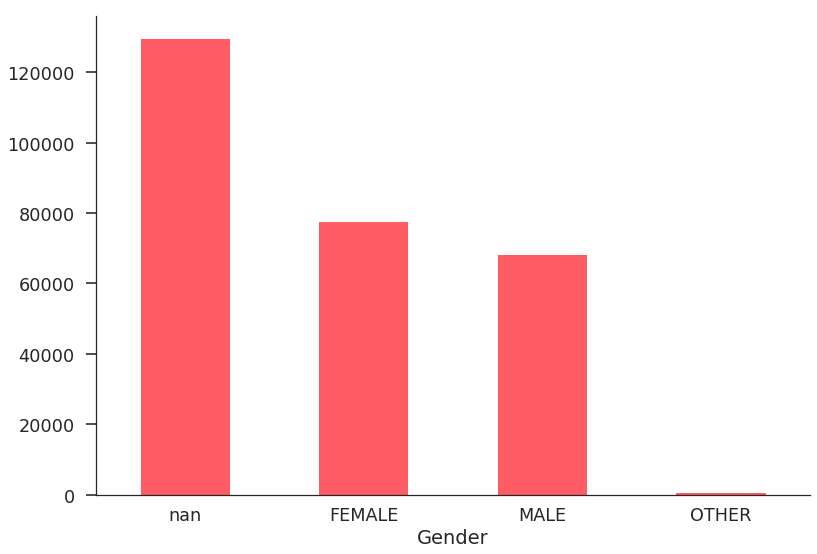

In [18]:
users.gender.value_counts(dropna=False).plot(kind='bar', color='#FD5C64', rot=0)
plt.xlabel('Gender')
sns.despine()

The above plot helps us to visuvalize the amount of missing data for this feature. We can also notice that there is a slight difference in the counts between the user gender.

Next thing we looked at is to see if there is any gender preferences when travelling.As we can see in the plot there are no big differences between the 2 main genders.

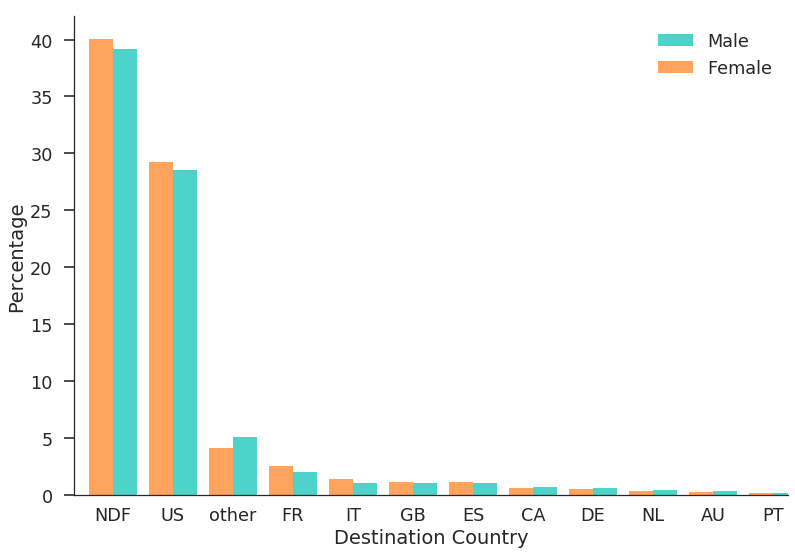

In [19]:
women = sum(users['gender'] == 'FEMALE')
men = sum(users['gender'] == 'MALE')

female_destinations = users.loc[users['gender'] == 'FEMALE', 'country_destination'].value_counts() / women * 100
male_destinations = users.loc[users['gender'] == 'MALE', 'country_destination'].value_counts() / men * 100

# Bar width
width = 0.4

male_destinations.plot(kind='bar', width=width, color='#4DD3C9', position=0, label='Male', rot=0)
female_destinations.plot(kind='bar', width=width, color='#FFA35D', position=1, label='Female', rot=0)

plt.legend()
plt.xlabel('Destination Country')
plt.ylabel('Percentage')

sns.despine()
plt.show()

#### Country Destination

We plotted the counts of the country destination . As seen in the figure below nearly 60% of the customers end up not making a booking. Among the customers who do end up making a booking US is the preffered destination for more than 2/3 rd's.

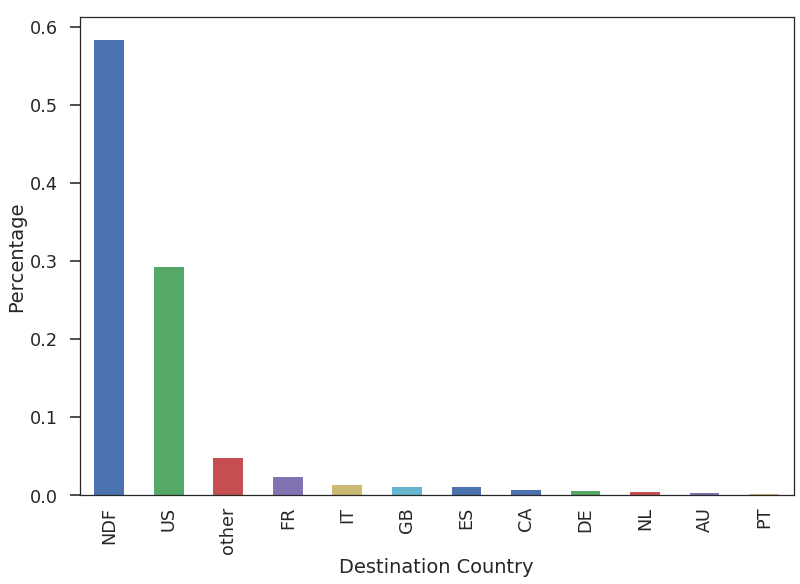

In [20]:
counts =  users.country_destination.value_counts(normalize=True).plot(kind='bar')
plt.xlabel('Destination Country')
plt.ylabel('Percentage')

#### Age

The plot of the age data of the users in the traning and test data is as below.

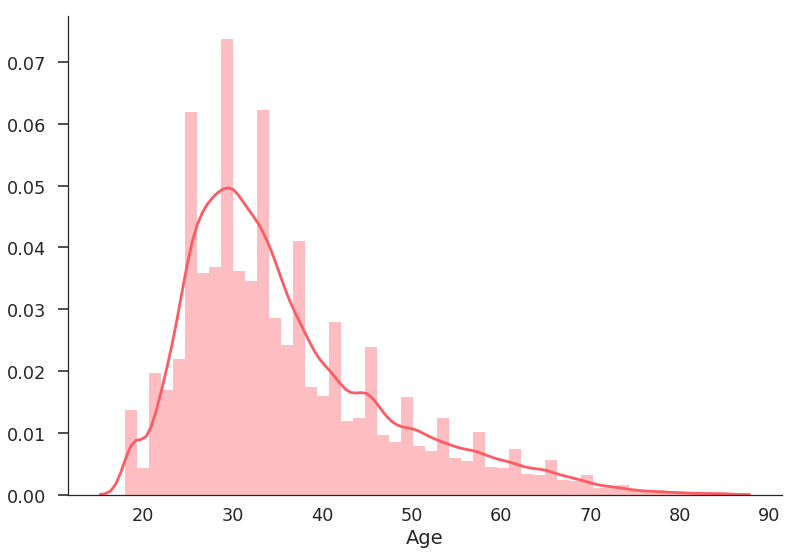

In [21]:
sns.distplot(users.age.dropna(), color='#FD5C64')
plt.xlabel('Age')
sns.despine()

As we would expect, the common age to travel is between 25 and 40. We wanted to further explore if there is difference in the booking patterns based on the age of the users. We took a arbitratry split range of 50 and plotted the below graph .

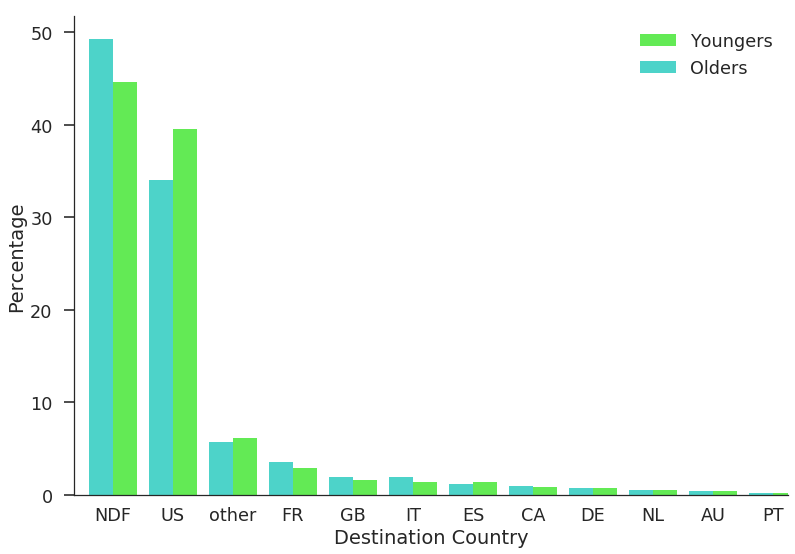

In [22]:
age = 50

younger = sum(users.loc[users['age'] < age, 'country_destination'].value_counts())
older = sum(users.loc[users['age'] > age, 'country_destination'].value_counts())

younger_destinations = users.loc[users['age'] < age, 'country_destination'].value_counts() / younger * 100
older_destinations = users.loc[users['age'] > age, 'country_destination'].value_counts() / older * 100

younger_destinations.plot(kind='bar', width=width, color='#63EA55', position=0, label='Youngers', rot=0)
older_destinations.plot(kind='bar', width=width, color='#4DD3C9', position=1, label='Olders', rot=0)

plt.legend()
plt.xlabel('Destination Country')
plt.ylabel('Percentage')

sns.despine()
plt.show()

We can see that the young people tend to stay in the US, and the older people choose to travel outside the country. 

### Language
We explore the language feature to understand the distribution and see it would make a good predictor for destination country.We can visuvalize below that language does capture variations in booking destination of the users. For example in the plot below for people with 'fr' language country destnation 'fr' is the second most preffered destination for first booking after 'US'.

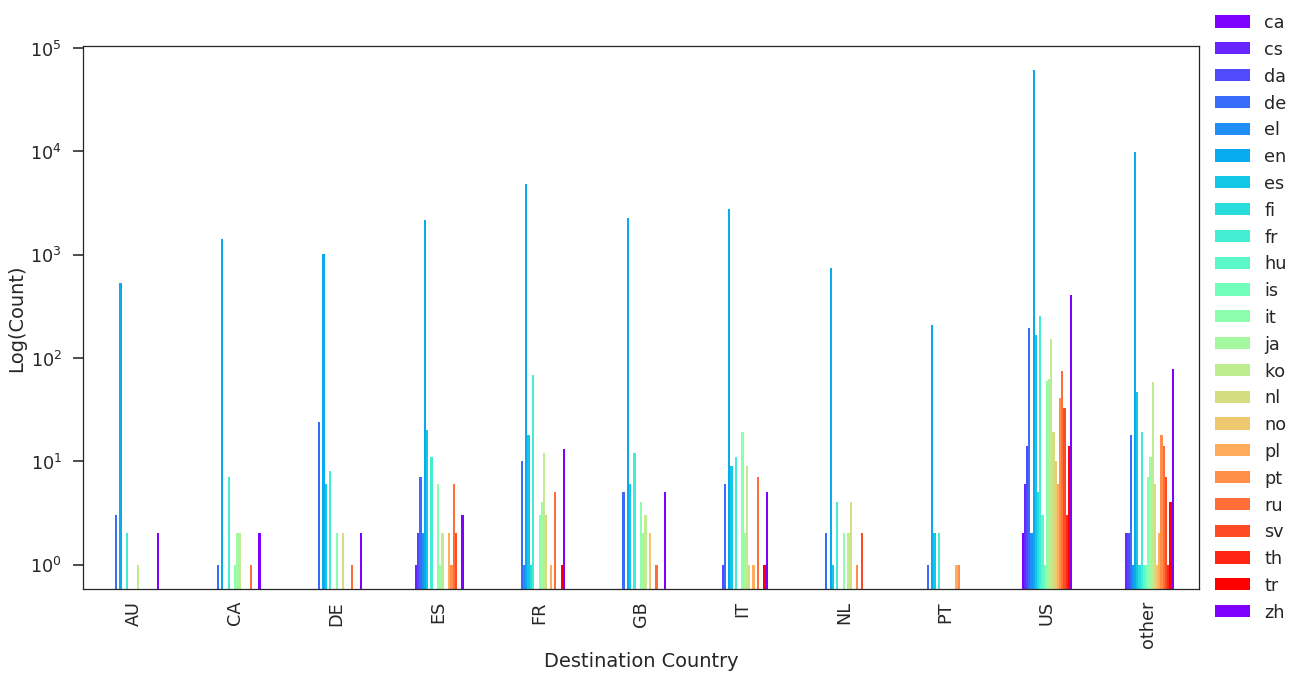

In [23]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0,1,22))
users[~(users['country_destination'].isin(['NDF']))].groupby(['country_destination' , 'language']).size().unstack().plot(kind='bar', figsize=(20,10),stacked=False,color=colors)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          ncol=1, fancybox=True, shadow=True)
plt.yscale('log')
plt.xlabel('Destination Country')
plt.ylabel('Log(Count)')

#### Dates

We next explore the date account created feature and plot the count of users created by date.

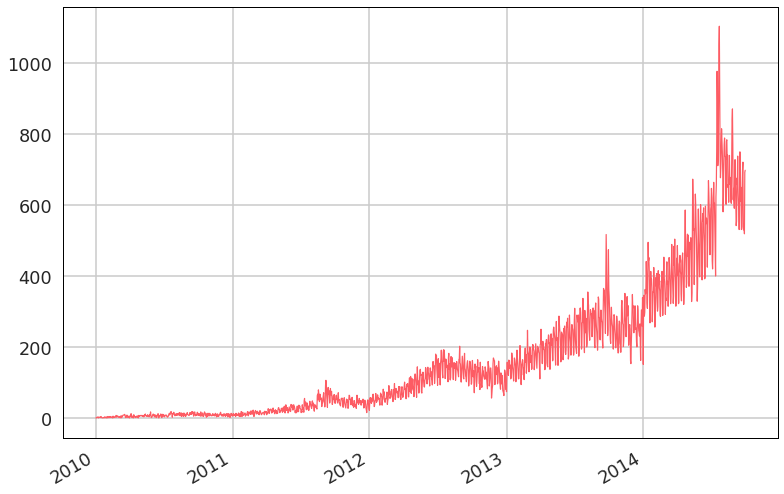

In [24]:
sns.set_style("whitegrid", {'axes.edgecolor': '0'})
sns.set_context("poster", font_scale=1.1)
users.date_account_created.value_counts().plot(kind='line', linewidth=1.2, color='#FD5C64')

We can visuvalize based on the graph how fast Airbnb has grown from 2012. We next plot the first time active field to see if the feature correlates with the date of user creation . We can see from the below graph there is a very close correlation between the two date fields.

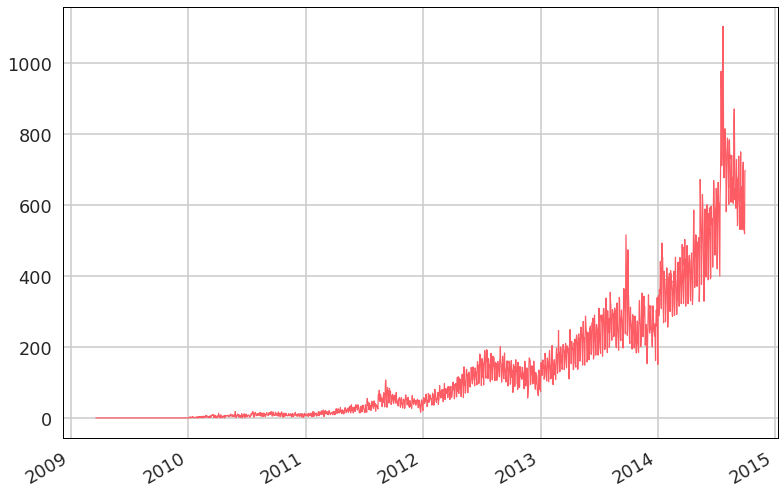

In [25]:
date_first_active = users.date_first_active.apply(lambda x: datetime.datetime(x.year, x.month, x.day))
date_first_active.value_counts().plot(kind='line', linewidth=1.2, color='#FD5C64')

In [26]:
users['date_account_created'] = pd.to_datetime(users['date_account_created'], errors='ignore')
users['date_first_active'] = pd.to_datetime(users['timestamp_first_active'], format='%Y%m%d%H%M%S')
users['date_first_booking'] = pd.to_datetime(users['date_first_booking'], errors='ignore')

We see minor ups and down in the date plot to understand this variation better we plotted the count of number of users who signed up in Airbnb for each month. We can see that  is a general upward trend in the number of users that are created however we can aslo see there is a pattern in the number of users that sign up for each month possibly a indication of an underlying trend. This is something this we would anticipate for Airbnb as people would tend to travel more during summer and holidays and travel less in other months.

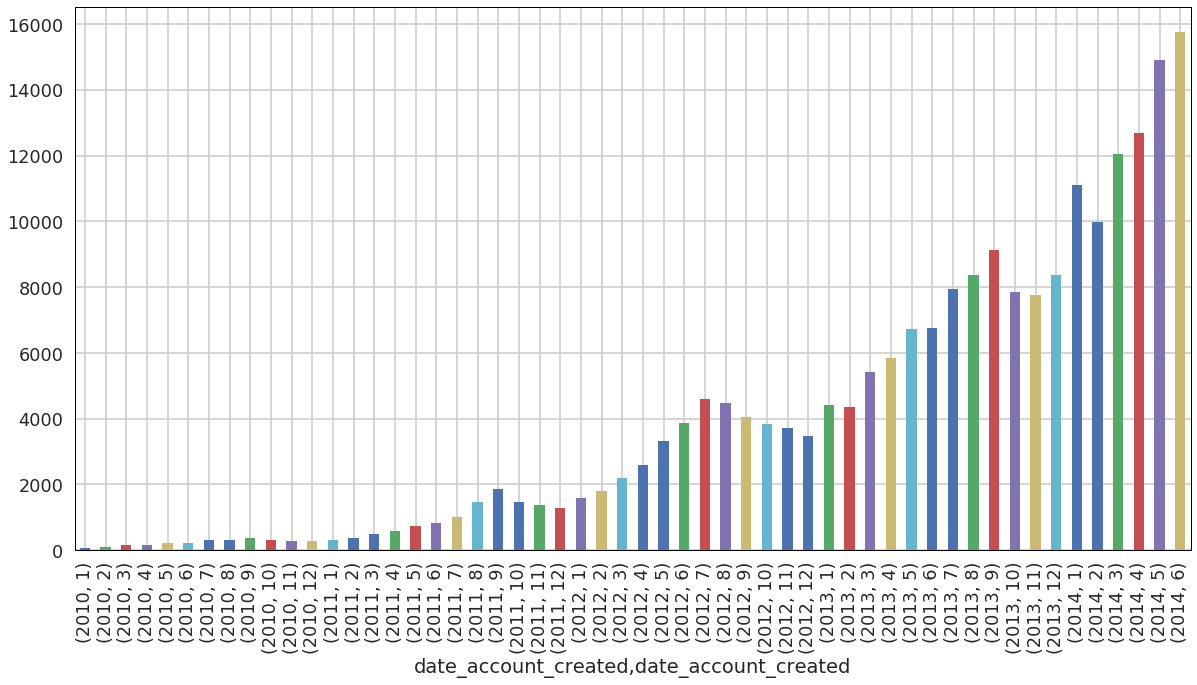

In [27]:
df = users[~users['country_destination'].isnull()]
df.groupby([df["date_account_created"].dt.year, df["date_account_created"].dt.month])['country_destination'].count().plot(kind="bar",figsize=(20,10))

We further explore the month dependency by plotting the month of booking vs country destinations. We can see from the plot below that inaddition to the variations in the total number of bookings by month we also see a variations in the destination that was booked.
For example from the plot below Australia has significantly higher bookings in months 11 and 12 (November and December) compared to other months.

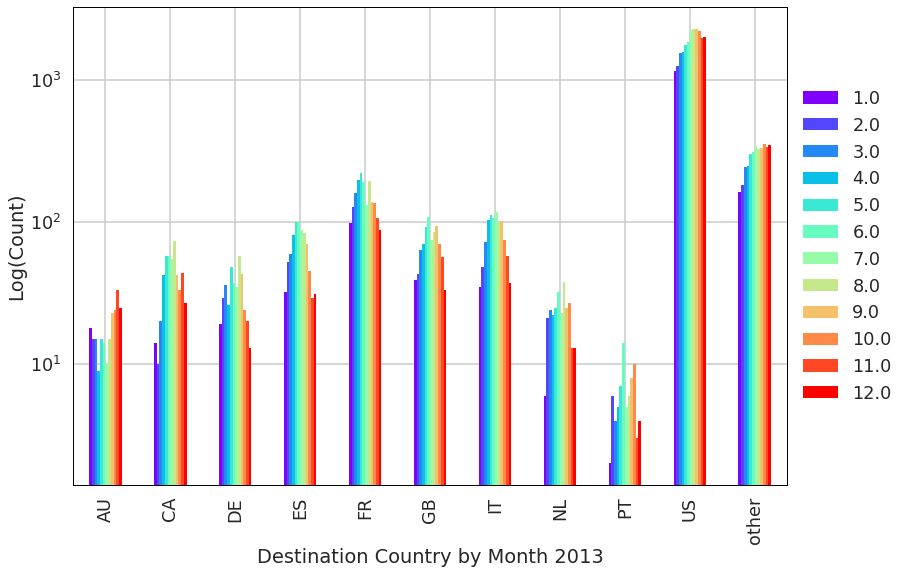

In [28]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0,1,12))
df[df["date_first_booking"].dt.year == 2013].groupby(['country_destination' , df["date_first_booking"].dt.month]).size().unstack().plot(kind='bar', stacked=False,color=colors)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          ncol=1, fancybox=True, shadow=True)
plt.yscale('log')
plt.xlabel('Destination Country by Month 2013')
plt.ylabel('Log(Count)')

### Affiliate Information

Below is a plot of the number of bookings per destination by affiliate channel/affiliate provider/first affiliate tracked. We can see a disernable pattern . So all these three features are good predictors of the destination country.

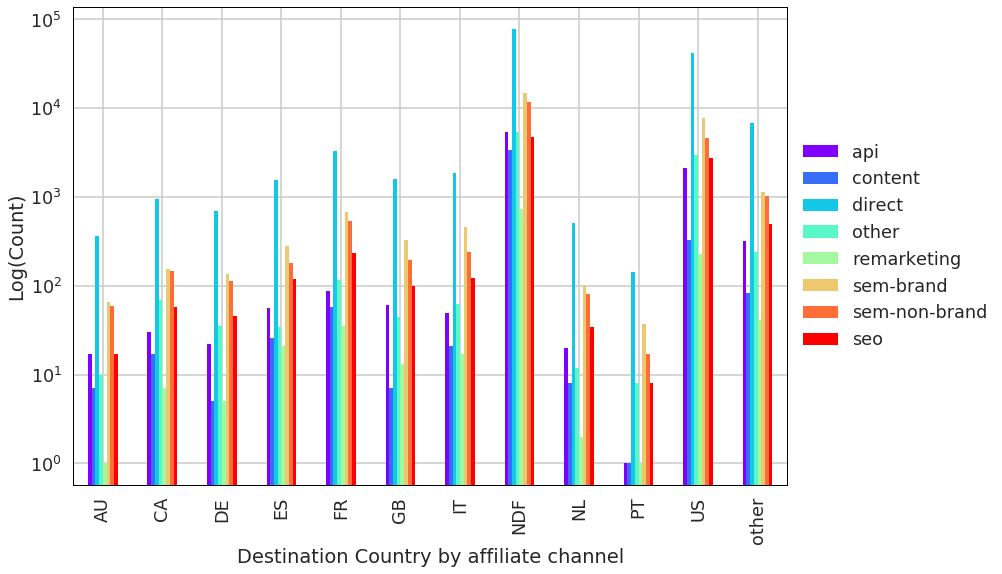

In [29]:
colors = cm.rainbow(np.linspace(0,1,users['affiliate_channel'].nunique()))
users.groupby(['country_destination','affiliate_channel']).size().unstack().plot(kind='bar', stacked=False,color=colors)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          ncol=1, fancybox=True, shadow=True)
plt.yscale('log')
plt.xlabel('Destination Country by affiliate channel')
plt.ylabel('Log(Count)')

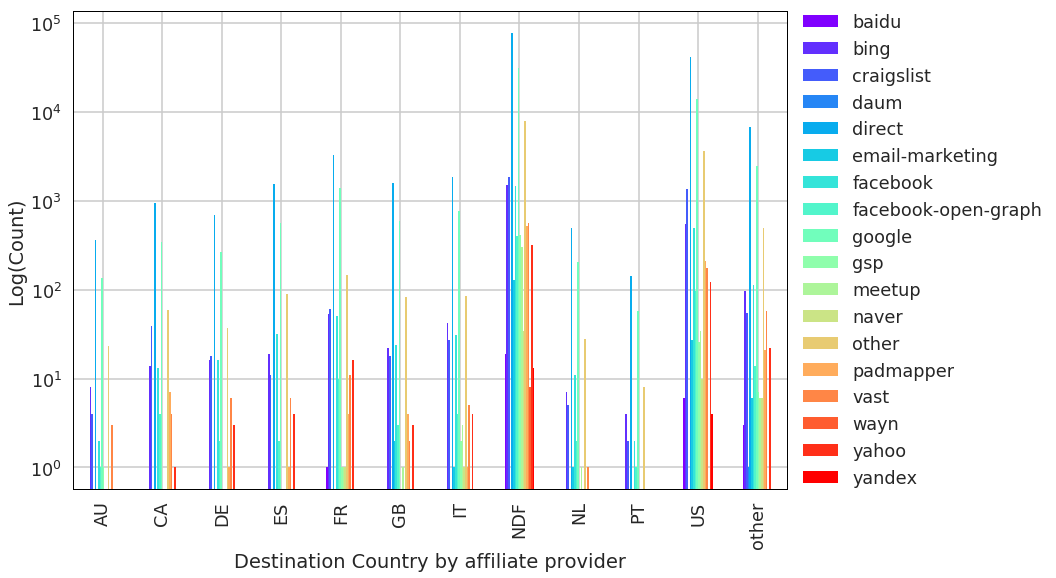

In [30]:
colors = cm.rainbow(np.linspace(0,1,users['affiliate_provider'].nunique()))
users.groupby(['country_destination','affiliate_provider']).size().unstack().plot(kind='bar', stacked=False,color=colors)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          ncol=1, fancybox=True, shadow=True)
plt.yscale('log')
plt.xlabel('Destination Country by affiliate provider')
plt.ylabel('Log(Count)')

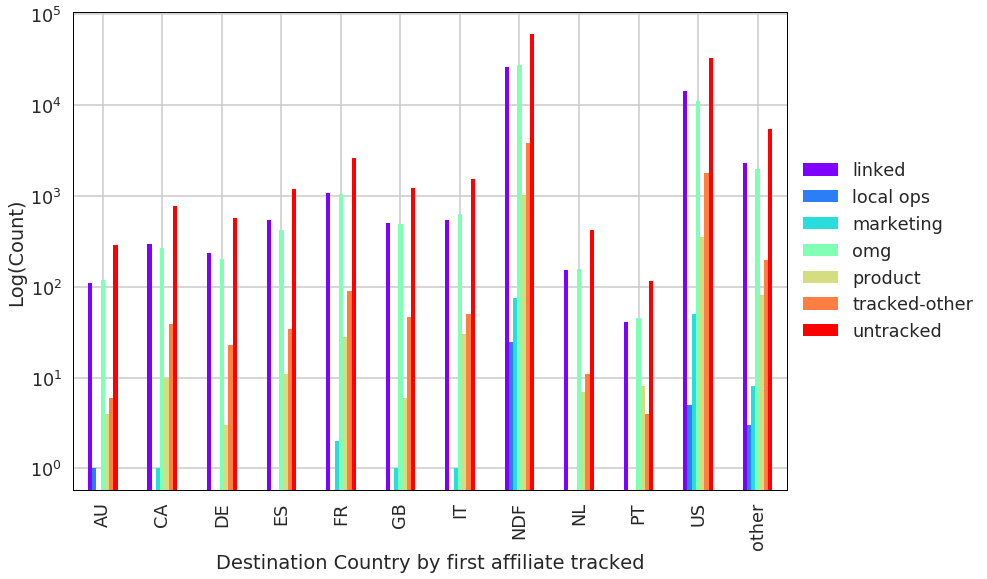

In [31]:
colors = cm.rainbow(np.linspace(0,1,users['first_affiliate_tracked'].nunique()))
users.groupby(['country_destination','first_affiliate_tracked']).size().unstack().plot(kind='bar', stacked=False,color=colors)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          ncol=1, fancybox=True, shadow=True)
plt.yscale('log')
plt.xlabel('Destination Country by first affiliate tracked')
plt.ylabel('Log(Count)')

## 3. Preprocessing

## Age
In the data exploration we already noted that the Age was key feature for predicting destinations. We are also aware of the outiers ie values greater than 85 and less than 18 . In this step we clean the outliers so that they dont adversely affect our model. 

Also , Age is really fine grained. We are going to make bins and fit each user in the proper age group so that we can predict it in categories. Below is a plot of the numbers of users in each Age group . Group 0 is largest which represents the users with no age data.

In [32]:
import numpy as np
import pandas as pd
users.loc[users.age > 85, 'age'] = np.nan
users.loc[users.age < 18, 'age'] = np.nan
users['age'].fillna(-1,inplace=True)
bins = [-1, 0, 4, 9, 14, 19, 24, 29, 34,39,44,49,54,59,64,69,74,79,84,89]
users['age_group'] = np.digitize(users['age'], bins, right=True)

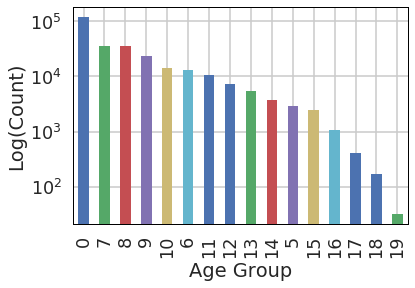

In [33]:
%matplotlib inline
users.age_group.value_counts().plot(kind='bar')
plt.yscale('log')
plt.xlabel('Age Group')
plt.ylabel('Log(Count)')

## Date
We first cast the date records to proper date format. We had noted in the exploration that the month in which either the user signed up in Airbnb or booked in Airbnb is good predictor for the destination the user will book . So from the create date we parse out the month , week day as seperate features. We also create new features based on the date first active field which includes a time stamp. We create month first active , week day first active variable. In addition to this we also create a hour first active as we hypotesize that someone creating a account for the first time at odd hours are more likely to make a booking . 

In [34]:
df = users[users['country_destination'].isnull()]

In [35]:
date_account_created = pd.DatetimeIndex(users['date_account_created'])
date_first_active = pd.DatetimeIndex(users['date_first_active'])
date_first_booking = pd.DatetimeIndex(users['date_first_booking'])

In [36]:
#users['day_account_created'] = date_account_created.day
users['weekday_account_created'] = date_account_created.weekday
#users['week_account_created'] = date_account_created.week
users['month_account_created'] = date_account_created.month
#users['year_account_created'] = date_account_created.year
#users['day_first_active'] = date_first_active.day
users['weekday_first_active'] = date_first_active.weekday
#users['week_first_active'] = date_first_active.week
users['month_first_active'] = date_first_active.month
users['month_first_book'] = date_first_booking.month
users['hour_first_active'] = date_first_active.hour
#users['year_first_active'] = date_first_active.year

In [37]:
users['time_lag_create'] = (date_first_booking - date_account_created).days
users['time_lag_active'] = (date_first_booking - date_first_active).days
users['time_lag_create'].fillna(365,inplace=True)
users['time_lag_active'].fillna(365,inplace=True)

Next we create two new features from the dates one is the __time lag create__ which is the time in days between the date of creation and date the customer made the first booking in Airbnb and the second one is __time lag active__ which is the time in days between the date the customer was first active to the date the customer made the first booking . The below plot's show that the time lag features will be able to effectively predict both whether a customer will make a booking or not and also the ultimate destination the customer will make the booking.

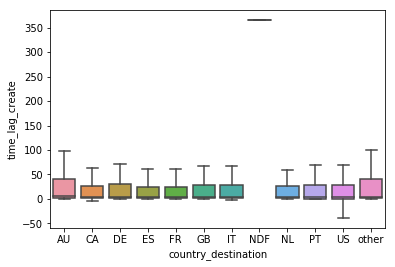

In [38]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import importlib
importlib.reload(mpl); importlib.reload(plt); importlib.reload(sns)
ax = sns.boxplot(x="country_destination", y="time_lag_create", showfliers=False,data=users[~(users['country_destination'].isnull())])
#users[~(users['country_destination'].isnull())][['time_lag_create','country_destination']].boxplot(by='country_destination')

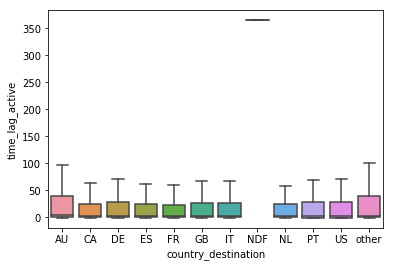

In [39]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import importlib
importlib.reload(mpl); importlib.reload(plt); importlib.reload(sns)
ax = sns.boxplot(x="country_destination", y="time_lag_active", showfliers=False,data=users[~(users['country_destination'].isnull())])
#users[~(users['country_destination'].isnull())][['time_lag_create','country_destination']].boxplot(by='country_destination')

In [40]:
users[['time_lag_create','time_lag_active']].describe()

,time_lag_create,time_lag_active
count,275547.000000,275547.000000
mean,261.543098,261.326812
std,157.921613,158.395423
min,-349.000000,-1.000000
25%,41.000000,41.000000
50%,365.000000,365.000000
75%,365.000000,365.000000
max,365.000000,1368.000000


In [41]:
users.loc[users.time_lag_create > 365, 'time_lag_create'] = 365
users.loc[users.time_lag_active > 365, 'time_lag_create'] = 365

In [42]:
drop_list = [
    'date_account_created',
    'date_first_active',
    'date_first_booking',
    'timestamp_first_active',
    'age'
]

users.drop(drop_list, axis=1, inplace=True)

## Session Information

There is a lot of information in the `sessions.csv` file. We extracted the below features from the sessions.csv file.


   - Count of each action types
   - Sum of time elapse for each action
   - Pertange of the time elapsed for each action type aginst the total elapsed time for a user
   - Count of unique number action detail
   - Count of number uniqe devices the user used

We merged all this data back with the users data. We had to note that the sessions file included data only from 1/1/2014 however the training data included users from 2010 so there were a large number of user records who dont have any session data . However for all test users we have the session data so we would expect the model do probably less efectively on the training set based on how we choose data to train and test but the model will probably do better on the the testing data.

In [43]:
sessions.rename(columns = {'user_id': 'id'}, inplace=True)

In [44]:
from sklearn import preprocessing
# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

action_count = sessions.groupby(['id'])['action'].nunique()

#action_count = pd.DataFrame(min_max_scaler.fit_transform(action_count.fillna(0)),columns=action_count.columns)
action_type_count = sessions.groupby(['id', 'action_type'])['secs_elapsed'].agg(len).unstack()
action_type_count.columns = action_type_count.columns.map(lambda x: str(x) + '_count')
#action_type_count = pd.DataFrame(min_max_scaler.fit_transform(action_type_count.fillna(0)),columns=action_type_count.columns)
action_type_sum = sessions.groupby(['id', 'action_type'])['secs_elapsed'].agg(sum)

action_type_pcts = action_type_sum.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum())).unstack()
action_type_pcts.columns = action_type_pcts.columns.map(lambda x: str(x) + '_pct')
action_type_sum = action_type_sum.unstack()
action_type_sum.columns = action_type_sum.columns.map(lambda x: str(x) + '_sum')
action_detail_count = sessions.groupby(['id'])['action_detail'].nunique()

#action_detail_count = pd.DataFrame(min_max_scaler.fit_transform(action_detail_count.fillna(0)),columns=action_detail_count.columns)

device_type_sum = sessions.groupby(['id'])['device_type'].nunique()

#device_type_sum = pd.DataFrame(min_max_scaler.fit_transform(device_type_sum.fillna(0)),columns=device_type_sum.columns)

sessions_data = pd.concat([action_count, action_type_count, action_type_sum,action_type_pcts,action_detail_count, device_type_sum],axis=1)
action_count = None
action_type_count = None
action_detail_count = None
device_type_sum = None


#users = users.join(sessions_data, on='id')

In [45]:
users= users.reset_index().join(sessions_data, on='id')

### Encode categorical features

The next step is to encode categorical features. The categorical variables in the data cannot be used as is in the machine learning models. We need to encode them into numeric values. We encoded the categorical variables using the __one hot encoding__ method. 

In [46]:
from sklearn.preprocessing import LabelEncoder
categorical_features = [
    'gender', 'signup_method', 'signup_flow', 'language',
    'affiliate_channel', 'age_group','weekday_account_created','month_account_created','weekday_first_active','month_first_active','hour_first_active',
    'signup_app','affiliate_provider', 'first_affiliate_tracked','first_device_type', 'first_browser'
]
users_sc = users.copy(deep=True)
encode = LabelEncoder()
for j in categorical_features:
    users_sc[j] = encode.fit_transform(users[j].astype('str'))

### Feature Selection

At the end of all preprocessing steps we had a total of 54 features that we have extracted from the users and sessions data set. Using all these features may lead to overfitting and could also be time consuming processing on many Machine learning algorithms. So in the next step we performed feature selection were we reduced the number of features using a standard sklearn  feature extraction library __VarianceThreshold__.

__VarianceThreshold__ is a simple baseline approach to feature selection. It removes all features whose variance doesn’t meet some threshold. By default, it removes all zero-variance features, i.e. features that have the same value in all samples.
As an example, suppose that we have a dataset with boolean features, and we want to remove all features that are either one or zero (on or off) in more than 80% of the samples. 

These features which are common for more than 80 % of the data dont necessarily capture all the avriations in the data and will not be good predictors . So we eliminate the variables with low threshold and arrived at a final list of features which are listed below.

Below is the final list of 43 features which we used to build our models.

In [47]:
colx = users_sc.columns.tolist()
rm_list = ['id','country_destination']
for x in rm_list:
    colx.remove(x)
X = users_sc[~(users_sc['country_destination'].isnull())][colx]
X.fillna(0,inplace=True)
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(0.8))
sel.fit_transform(X)
idxs = sel.get_support(indices=True)
colo = [X.columns.tolist()[i] for i in idxs]
print ('\n'.join(colo))
for y in rm_list:
    colo.append(y)

affiliate_channel
affiliate_provider
first_affiliate_tracked
first_browser
first_device_type
gender
language
signup_flow
age_group
weekday_account_created
month_account_created
weekday_first_active
month_first_active
month_first_book
hour_first_active
time_lag_create
time_lag_active
action
-unknown-_count
click_count
data_count
message_post_count
submit_count
view_count
-unknown-_sum
booking_request_sum
booking_response_sum
click_sum
data_sum
message_post_sum
partner_callback_sum
submit_sum
view_sum
-unknown-_pct
booking_request_pct
click_pct
data_pct
message_post_pct
submit_pct
view_pct
action_detail


In [48]:
categorical_features_1 = [val for val in categorical_features if val in colo]
users_encode = pd.get_dummies(users[colo], columns=categorical_features_1)
users_encode.to_csv('../cache/users_data_feature.csv')

### Countries and Age Bkdts dataset

Though the countries and the age dataset provide some valuable information on the destination countries and the age group of the population in these countries we find no use for them on the task at hand. If we had further information on the users in our dataset such as exact location in the US and other demographic details of users such as marital status, household income etc we could have possible used the data from the data sets to build a more robust prediction model. 

In [49]:
from time import time
from math import sqrt
import logging
import os
import sys
import csv
import datetime


total = {}
started = {}
model_perf={}

        
def start(key):
    started[key]=time()


def stop(key):
    stop=time()
    start=started.pop(key,None)
    if start:
        if key in total:
            total[key].append(stop-float(start))
        else:
            total[key]=[stop-float(start)]
    else:
        logging.error("stopping non started timer: %s"%key)

## 4. Model Building

We now proceed to model building stage . But before we start training the models we perform one last data preparation  step.

We split the training data in a 80:20 ratio and use the 80 percent of the data to build the model and 20 percent of the data to validate it. While splitting we used the stratify option in the sklearn library to ensure that the data that is selected includes a representative set of the user data with the country destinations in the same proportion as the full dataset. This is very essential since the distribution of the country destination is highly unbalanced .

### Time lag variables

 The time lage variables both __time_lag_create__ and __time_lag_active__ were identified as key features both by the variance threshold method and the Decision Tree and Random forest models we built. The models built with these features included had a accuracy value of __0.88__ and nDCG score of __0.92__ . However we were not able to use these models on the test dataset since the test data set doesnt have the date of booking for the users. We do believe that these values can be used very usefully in future where we have more data points and time related informtion on the session and user data sets. For current report we excluded these two variables from models.

In [50]:
from sklearn.model_selection import train_test_split
users = users_encode
users.set_index('id',inplace=True)
users.drop([col for col in users.columns if 'pct_booking_request' in col],axis=1,inplace=True)
users.drop([col for col in users.columns if 'booking_request_count' in col],axis=1,inplace=True)
colx = users.columns.tolist()
#colx_1 = users_data_1.columns.tolist()
rm_list = ['country_destination','month_first_book', 'time_lag_create','time_lag_active']
for x in rm_list:
    colx.remove(x)
X_1 = users[(users['country_destination'].isnull())][colx]
X_1.fillna(0,inplace=True)
X = users[~(users['country_destination'].isnull())][colx]
#X_1 = users_data_1[~(users_data_1['country_destination'].isnull())][colx_1]
Y = users[~(users['country_destination'].isnull())]['country_destination']
#Y_1 = users_data_1[~(users_data_1['country_destination'].isnull())]['country_destination']
X.fillna(0,inplace=True)
#X_1.fillna(0,inplace=True)
#X_res,Y_res = ada.fit_sample(X, Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42,stratify=Y)
#X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(X_1, Y_1, test_size=0.2, random_state=42,stratify=Y)

## Logistic Regression - OVR
We first built a Logistic regression model optimised for OVR (One Vs Rest). Since more than 3/4 of the country destination is accounted for by 'NDF' and 'US' we evaluated the performance of the Logistic Regression model  optimised to minimize the loss for OVR.

In [51]:
from sklearn.linear_model import LogisticRegression
start('logr')
logr = LogisticRegression()
logr.fit(X_train, Y_train)
stop('logr')

## Logistic Regression - Multinomial
Next we built built a Logistic regression Multinomial classification model. Since the primary objective of the problem at hand was to predict the possible destination a user will book we hypothesized that this model may have a lower accuracy score but it will do better on the nDCG score.

In [52]:
from sklearn.linear_model import LogisticRegression
start('logr_mlt')
logr_mlt = LogisticRegression(n_jobs=1,multi_class='multinomial',solver='newton-cg')
logr_mlt.fit(X_train, Y_train)
stop('logr_mlt')

## SVM Linear
Next we built built a SVM-Linear Classifier model. SVM - Linear classification is not well suited to the problem at hand since they cannot predict probabilities for the target classes. However we wanted to evaluate how well the model does for a single value prediction .

In [53]:
from sklearn.svm import LinearSVC
start('svc')
svc = LinearSVC(random_state=42)
svc.fit(X_train, Y_train)
stop('svc')

## Decision Tree

Next we built a decision tree classifier. Since this was a multiclass classification problem decision tree is well suited for the problem at hand . The key features in the model and their weights are detailed below.

In [54]:
from sklearn.tree import DecisionTreeClassifier
start('dt')
dt = DecisionTreeClassifier()
dt.fit(X_train, Y_train)
stop('dt')

In [55]:
feature_imp = pd.DataFrame(sorted(zip(map(lambda x: round(x, 4), dt.feature_importances_), X.columns.tolist()), 
             reverse=True))
feature_imp.columns = ['value','feature']
feature_imp.set_index('feature',inplace=True)
feature_imp.head(10)

,value
feature,
age_group_0,0.0655
data_sum,0.0139
first_browser_Chrome,0.0130
data_pct,0.0130
booking_request_pct,0.0130
view_pct,0.0129
click_pct,0.0126
message_post_count,0.0124
hour_first_active_22,0.0123


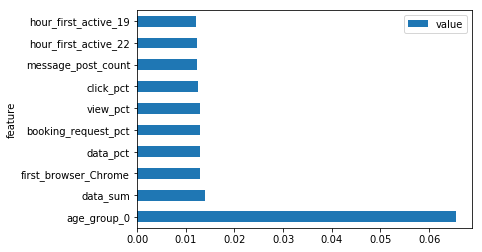

In [56]:
%matplotlib inline
feature_imp.nlargest(10,'value').plot(kind='barh')

## Random Forest

Next we built a Random forest classifier. Random forest or random decision forest is an ensemble learning method for classification, regression and other tasks, that operate's by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. Random decision forest correct for decision trees' habit of overfitting to their training set. The key features and the weights as identified by the Random Forest model are detailed below.

In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
start('rf')
clf = RandomForestClassifier(n_estimators=64,n_jobs=-1)
clf.fit(X_train, Y_train)
stop('rf')

In [58]:
feature_imp = pd.DataFrame(sorted(zip(map(lambda x: round(x, 4), clf.feature_importances_), X.columns.tolist()), 
             reverse=True))
feature_imp.columns = ['value','feature']
feature_imp.set_index('feature',inplace=True)
feature_imp.nlargest(10,'value')

,value
feature,
age_group_0,0.0388
gender_FEMALE,0.0143
first_browser_Chrome,0.0137
gender_MALE,0.0135
hour_first_active_21,0.0124
hour_first_active_19,0.0124
hour_first_active_18,0.0124
hour_first_active_20,0.0122
first_affiliate_tracked_untracked,0.0122


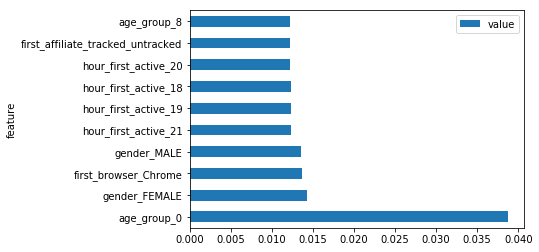

In [59]:
%matplotlib inline
feature_imp.nlargest(10,'value').plot(kind='barh')

## 5. Results

### Logistic Regression - OVR

The confusion matrix for the Logistic Regression - OVR method is as below. As we can see in the table the model does a pretty could job of predicting NDF however prediction accruacy is very low for all the other destinations. The accuracy for this model is __0.59__ . 

We also calculated the nDCG score by predicting the probability for each for destinations for each of the users. The Logistic Regression - OVR method got a nDCG score of __0.7618__

In [60]:
start('logr')
y_pred_logr=logr.predict(X_test)
stop('logr')
pd.crosstab(Y_test, y_pred_logr, rownames=['Actual Destination'], colnames=['Predicted Destination'])

Predicted Destination,ES,NDF,NL,US,other
Actual Destination,,,,,
AU,0,105,0,3,0
CA,0,276,0,10,0
DE,0,203,0,9,0
ES,0,432,0,18,0
FR,3,965,0,37,0
GB,0,440,0,25,0
IT,0,534,0,33,0
NDF,9,24540,2,358,0
NL,0,147,0,5,0


In [61]:
from sklearn.metrics import accuracy_score,confusion_matrix
print ('Accuracy:' + str(accuracy_score(Y_test, y_pred_logr)))
model_perf['logr','Accuracy'] = accuracy_score(Y_test, y_pred_logr)

Accuracy:0.590452320161


In [62]:
"""Metrics to compute the model performance."""

import numpy as np
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import make_scorer


def dcg_score(y_true, y_score, k=5):
    """Discounted cumulative gain (DCG) at rank K.

    Parameters
    ----------
    y_true : array, shape = [n_samples]
        Ground truth (true relevance labels).
    y_score : array, shape = [n_samples, n_classes]
        Predicted scores.
    k : int
        Rank.

    Returns
    -------
    score : float
    """
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)


def ndcg_score(ground_truth, predictions, k=5):
    """Normalized discounted cumulative gain (NDCG) at rank K.

    Normalized Discounted Cumulative Gain (NDCG) measures the performance of a
    recommendation system based on the graded relevance of the recommended
    entities. It varies from 0.0 to 1.0, with 1.0 representing the ideal
    ranking of the entities.

    Parameters
    ----------
    ground_truth : array, shape = [n_samples]
        Ground truth (true labels represended as integers).
    predictions : array, shape = [n_samples, n_classes]
        Predicted probabilities.
    k : int
        Rank.

    Returns
    -------
    score : float

    Example
    -------
    >>> ground_truth = [1, 0, 2]
    >>> predictions = [[0.15, 0.55, 0.2], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    1.0
    >>> predictions = [[0.9, 0.5, 0.8], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    0.6666666666
    """
    lb = LabelBinarizer()
    lb.fit(range(predictions.shape[1]+ 1))
    T = lb.transform(ground_truth)


    scores = []

    # Iterate over each y_true and compute the DCG score
    for y_true, y_score in zip(T, predictions):
        actual = dcg_score(y_true, y_score, k)
        best = dcg_score(y_true, y_true, k)
        score = float(actual) / float(best)
        scores.append(score)

    return np.mean(scores)

y_conv = [clf.classes_.tolist().index(k) for k in Y_test.tolist()] 
start('logr')
y_pred_prob_logr=logr.predict_proba(X_test)
stop('logr')
print('nDCG:' + str(ndcg_score(y_conv,y_pred_prob_logr)))
model_perf['logr','nDCG'] = ndcg_score(y_conv,y_pred_prob_logr)
#pd.DataFrame(y_pred_prob,columns=clf.classes_)

nDCG:0.761802605855


### Logistic Regression - Multinomial

The confusion matrix for the Logistic Regression - Multinomial method is as below. As we can see in the table the model does a pretty could job of predicting NDF however prediction accruacy is very low for all the other destinations. The accuracy for this model is __0.58__ . 

We also calculated the nDCG score by predicting the probability for each for destinations for each of the users. The Logistic Regression - Multinomial method got a nDCG score of __0.8070__.

Also as we had hypothesized though this model was less accurate than the Logistic regression - OVR model we got a significantly higher nDCG score than the Logistic regression - OVR model.

In [63]:
start('logr_mlt')
y_pred_logr_mlt=logr_mlt.predict(X_test)
stop('logr_mlt')
pd.crosstab(Y_test, y_pred_logr_mlt, rownames=['Actual Destination'], colnames=['Predicted Destination'])

Predicted Destination,NDF,PT,US
Actual Destination,,,
AU,107,0,1
CA,282,0,4
DE,206,0,6
ES,440,0,10
FR,989,0,16
GB,448,0,17
IT,547,0,20
NDF,24675,1,233
NL,148,0,4


In [64]:
from sklearn.metrics import accuracy_score,confusion_matrix
print ('Accuracy:' + str(accuracy_score(Y_test, y_pred_logr_mlt)))
model_perf['logr_mlt','Accuracy'] = accuracy_score(Y_test, y_pred_logr_mlt)

Accuracy:0.587196364573


In [65]:
start('logr_mlt')
y_pred_prob_logr_mlt=logr_mlt.predict_proba(X_test)
stop('logr_mlt')
print('nDCG:' + str(ndcg_score(y_conv,y_pred_prob_logr_mlt)))
model_perf['logr_mlt','nDCG'] = ndcg_score(y_conv,y_pred_prob_logr_mlt)

nDCG:0.807007117608


### SVM Linear
The confusion matrix for the SVM Linear Classifier method is as below. As we can see in the table the model fares very badly in predicting almost all destinations. The accuracy for this model is __0.48__ . This indicates the decision bouandries are not linear and we should explore non linear SVM model. We were unable to compute the nDCG score for this model as the SVM Linear 
method cannot predict probabilities for all the classes.

In [66]:
start('svc')
y_pred_svc=svc.predict(X_test)
stop('svc')
pd.crosstab(Y_test, y_pred_svc, rownames=['Actual Destination'], colnames=['Predicted Destination'])

Predicted Destination,AU,CA,DE,ES,FR,GB,IT,NDF,NL,US,other
Actual Destination,,,,,,,,,,,
AU,0,0,0,0,10,0,1,62,0,35,0
CA,0,9,0,1,26,0,1,159,1,87,2
DE,1,3,1,1,13,0,1,129,0,62,1
ES,0,7,0,0,46,0,3,252,1,141,0
FR,4,19,0,2,80,0,3,568,5,323,1
GB,4,12,0,0,47,0,5,253,0,142,2
IT,5,11,1,0,60,1,4,310,3,169,3
NDF,119,544,38,116,3028,26,120,16546,69,4250,53
NL,0,8,0,0,16,0,1,77,0,50,0


In [67]:
from sklearn.metrics import accuracy_score,confusion_matrix
print ('Accuracy:' + str(accuracy_score(Y_test, y_pred_svc)))
model_perf['svc','Accuracy'] = accuracy_score(Y_test, y_pred_svc)

Accuracy:0.482724696072


### Decision Tree

The confusion matrix for the Decision tree classifier is as below. As we can see in the table the model does a pretty could job of predicting NDF however predictiong is very low for all the other destinations. The accuracy for this model is __0.51__. 

We also calculated the nDCG score by predicting the probability for each for destinations for each of the users. The Decision tree model got a nDCG score of __0.69__

In [68]:
start('dt')
y_pred_dt=dt.predict(X_test)
stop('dt')
pd.crosstab(Y_test, y_pred_dt, rownames=['Actual Destination'], colnames=['Predicted Destination'])

Predicted Destination,AU,CA,DE,ES,FR,GB,IT,NDF,NL,PT,US,other
Actual Destination,,,,,,,,,,,,
AU,0,1,0,2,9,0,0,50,2,0,37,7
CA,0,1,3,3,11,3,5,137,2,0,106,15
DE,3,3,1,0,6,6,6,90,0,0,83,14
ES,6,3,2,7,16,6,4,209,2,1,173,21
FR,4,6,6,18,32,16,17,505,4,0,351,46
GB,0,3,6,12,7,1,11,234,2,0,159,30
IT,1,1,2,8,17,8,9,292,1,1,203,24
NDF,45,153,91,226,453,220,304,16925,61,16,5559,856
NL,1,1,1,2,5,2,4,61,0,0,67,8


In [69]:
from sklearn.metrics import accuracy_score,confusion_matrix
print ('Accuracy:' + str(accuracy_score(Y_test, y_pred_dt)))
model_perf['dt','Accuracy'] = accuracy_score(Y_test, y_pred_dt)

Accuracy:0.510786816893


In [70]:
start('dt')
y_pred_prob_dt=dt.predict_proba(X_test)
stop('dt')
print('nDCG:' + str(ndcg_score(y_conv,y_pred_prob_dt)))
ndcg_score(y_conv,y_pred_prob_dt)
model_perf['dt','nDCG'] = ndcg_score(y_conv,y_pred_prob_dt)

nDCG:0.692985103317


###  Random Forest

The confusion matrix for the Random tree classifier is as below. As we can see in the table the model does a pretty could job of predicting NDF as well US destinations however accuracy is very low for all the other destinations. The accuracy for this model is __0.60__ . 

We also calculated the nDCG score by predicting the probability for each for destinations for each of the users. The Decion tree model got a nDCG score of __0.80__.

In [71]:
start('rf')
y_pred=clf.predict(X_test)
stop('rf')
pd.crosstab(Y_test, y_pred, rownames=['Actual Destination'], colnames=['Predicted Destination'])

Predicted Destination,AU,CA,DE,ES,FR,GB,IT,NDF,NL,PT,US,other
Actual Destination,,,,,,,,,,,,
AU,0,0,0,0,0,0,0,65,0,0,42,1
CA,0,0,0,0,1,0,1,164,0,0,117,3
DE,0,0,0,0,0,0,0,129,0,0,81,2
ES,0,2,0,1,2,0,1,278,0,0,164,2
FR,0,0,1,0,1,0,0,609,1,0,388,5
GB,0,1,0,0,1,0,0,285,1,0,174,3
IT,0,0,0,0,1,1,2,347,0,0,216,0
NDF,3,13,8,14,46,19,32,20741,3,1,3926,103
NL,0,0,0,0,1,1,0,92,0,0,58,0


In [72]:
from sklearn.metrics import accuracy_score,confusion_matrix
print ('Accuracy:' + str(accuracy_score(Y_test, y_pred)))
model_perf['rf','Accuracy'] = accuracy_score(Y_test, y_pred)

Accuracy:0.604038321895


In [73]:
start('rf')
y_pred_prob=clf.predict_proba(X_test)
stop('rf')
print('nDCG:' + str(ndcg_score(y_conv,y_pred_prob)))
model_perf['rf','nDCG'] = ndcg_score(y_conv,y_pred_prob)

nDCG:0.805144161362


### Predict for Test Dataset

As a final step we predict the top 5 destination countries for each users based on the probabilities predicted from the trained models and order the results in the format as mandated by the competitions and submit it to kaggle. Below is a screen shot of submissions from Kaggle. As depicted in the summary table the Random Forest Model performed best of all the models closely followed by Logistic Regression Multinomial. 

Also from the random forest method did excellently on speed as well and its run times for the same data was only 12 seconds compared to nearly 700+ seconds run time of the Logistic regression multinomial which was the closest in terms on the nDCG score in our final submission.

In [74]:
y_pred_prob_1=dt.predict_proba(X_1)
id_test = X_1.reset_index()['id']
ids = []  #list of ids
cts = []  #list of countries
for i in range(len(id_test)):
    idx = id_test[i]
    ids += [idx] * 5
    arr = [clf.classes_.tolist()[k] for k in np.argsort(y_pred_prob_1[i])[::-1]] 
    cts += arr[:5]

#Generate submission
sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
sub.to_csv('../data/sub_dt.csv',index=False)

In [75]:
y_pred_prob_1=clf.predict_proba(X_1)
id_test = X_1.reset_index()['id']
ids = []  #list of ids
cts = []  #list of countries
for i in range(len(id_test)):
    idx = id_test[i]
    ids += [idx] * 5
    arr = [clf.classes_.tolist()[k] for k in np.argsort(y_pred_prob_1[i])[::-1]] 
    cts += arr[:5]

#Generate submission
sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
sub.to_csv('../data/sub_rf.csv',index=False)

In [76]:
y_pred_prob_1=logr.predict_proba(X_1)
id_test = X_1.reset_index()['id']
ids = []  #list of ids
cts = []  #list of countries
for i in range(len(id_test)):
    idx = id_test[i]
    ids += [idx] * 5
    arr = [clf.classes_.tolist()[k] for k in np.argsort(y_pred_prob_1[i])[::-1]] 
    cts += arr[:5]

#Generate submission
sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
sub.to_csv('../data/sub_logr.csv',index=False)

In [77]:
y_pred_prob_1=logr_mlt.predict_proba(X_1)
id_test = X_1.reset_index()['id']
ids = []  #list of ids
cts = []  #list of countries
for i in range(len(id_test)):
    idx = id_test[i]
    ids += [idx] * 5
    arr = [clf.classes_.tolist()[k] for k in np.argsort(y_pred_prob_1[i])[::-1]] 
    cts += arr[:5]

#Generate submission
sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
sub.to_csv('../data/sub_logr_mlt.csv',index=False)

#### Sample Output

In [78]:
sub.head(10)

,id,country
0,5uwns89zht,NDF
1,5uwns89zht,US
2,5uwns89zht,other
3,5uwns89zht,FR
4,5uwns89zht,IT
5,jtl0dijy2j,NDF
6,jtl0dijy2j,US
7,jtl0dijy2j,other
8,jtl0dijy2j,FR
9,jtl0dijy2j,IT


#### Kaggle Results

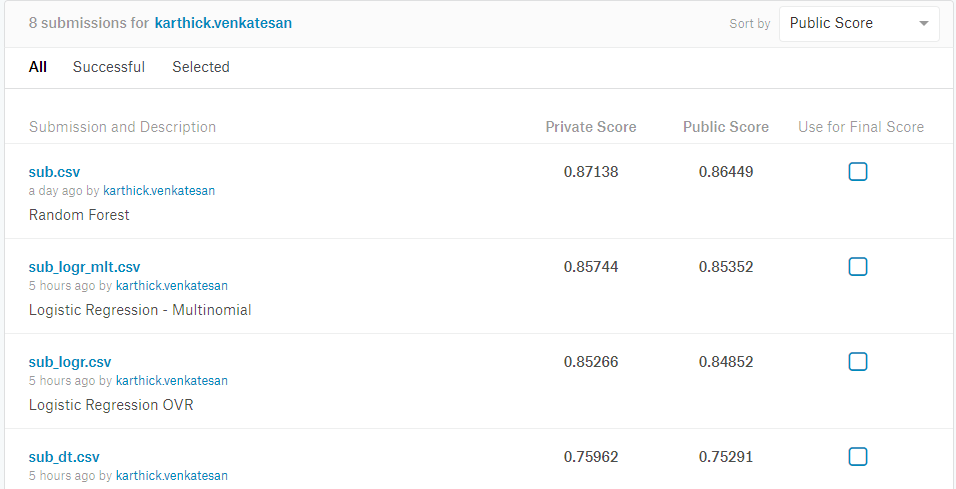

In [79]:
from IPython.display import Image
Image("../data/Kaggle.png")

#### Summary Results

In [80]:
model1 = {}
value = {}
kag= {'dt':0.75291,'logr':0.84852,'logr_mlt':0.85352,'rf':0.86449}
desc = {'dt':'Decision Tree','logr':'Logistic Regression OVR','logr_mlt':'Logistic Regression - Multinomial','rf':'Random Forest','svc':'Support Vector Classifier'}
for j in model_perf.keys():
    if desc[j[0]] not in model1.keys():
        value = {}
        value['Time(s)'] = total[j[0]][0]
        if j[0] in kag.keys():
            value['kaggle_nDCG'] = kag[j[0]] 
    value[j[1]] = model_perf[j]
    model1[desc[j[0]]] = value
        
pd.DataFrame(model1).T

,Accuracy,Time(s),kaggle_nDCG,nDCG
Decision Tree,0.510787,7.964606,0.75291,0.692985
Logistic Regression - Multinomial,0.587196,714.866235,0.85352,0.807007
Logistic Regression OVR,0.590452,251.514795,0.84852,0.761803
Random Forest,0.604038,11.925010,0.86449,0.805144
Support Vector Classifier,0.482725,467.602295,NaN,NaN


## 6. Conclusion

In conclusion we can see that the models based on Random Forest and Logistic Regression OVR , Logistic Regression Multinomial and Decision trees were able to predict the destination country of the users with more than 50 % accuracy and nDCG score greater than 0.75. The variables
identified as important in the model included both demographic features, such as gender, age, and
language, as well as the features we generated using the web sessions data, such as sum of
elapsed seconds and the count of unique user actions. Overall, we can see that the random
forest model is the best for the purpose of predicting whether a user will make a booking, as well as the destinations
of these bookings. In addition to be being the most accurate model the Random Forest model also was the fastest interms of runtimes compared to the other models. 

In future, we could further extend the study by building models such as Grandient Bosted trees and Neural networks. These models will require significant resources and most likely improve on the accuracy rates. We could also explore an ensemble classifer by using a combination of models for example both Logistic Regression and Random Forest. We could use Logistic Regression to perform the binary classification, and random forest to perform the multinomial classification. This will help us to better map the decision boundaries in the data set. Also as noted in the results age and geneder were significant in predicting the destination country . We could build prediction models and predict these missing demographic values based on the data in the sessions data set which would also help to improve the accuracy of our models.

The following additional data if present will significantly help in improving the prediction accuracy of the models. Firstly for almost 40% of the users we are missing the session data , this data if present will help in building better prediction models. Secondly the session data doesnt have a date for when the action was done. If we had this data we can use it to more accurately predict the destination booking by calculating the time lag variables which as already noted in the study were excellent predictors of country destination. Additionally, the default demographic data in Airbnb’s is fairly limited, and the predictors that
are included are littered with missing values and human input errors. One key predictor that could
potentially improve our predictions is the location of a user in the United States. For example, certain
cities in the United States may have sizable immigrant populations with ties back to European countries.
Residence in a particular city or region may suggest a higher likelihood of making a booking in a
particular. country. We also lack information about the potential number of travellers for a single
booking. Knowing that a user has a spouse and two kids in the household may suggest a higher
likelihood of booking in different places.